# Example: ML Pipeline with Funflow, Tensorflow, and Docker

In this example, we will examine a common use case for workflow tools: orchestrating the training and deployment of ML models. 
We've prepared two Python scripts: `train_mnist.py` and `inference_mnist.py`. These scripts contain logic for training an image classifier and 
making predictions using the trained classifier. They are written using the Python Tensorflow API and have some additional Python package dependencies which are
defined in a `requirements.txt` file. Our goal in this example is to use `funflow` to train a new model using `train_mnist.py` and test it out on some demo images using `inference_mnist.py`.

While you might already have Python and Tensorflow installed on your development machine, deploying these scripts to a production environment can be tricky. Docker containers are a common solution to this problem since they allow you to prepare an isolated environment which contains your application's dependencies. Lucky for us, `funflow` supports running `DockerTasks` out of the box, and there is a pre-prepared tensorflow image already available [on DockerHub](https://hub.docker.com/r/tensorflow/tensorflow/). All we need to do is add our script and its dependencies to it at runtime. Our `flow` will take care of running our scripts in Docker containers, passing the trained model between them, and extracting the final output.

Our final `flow` DAG will look like:
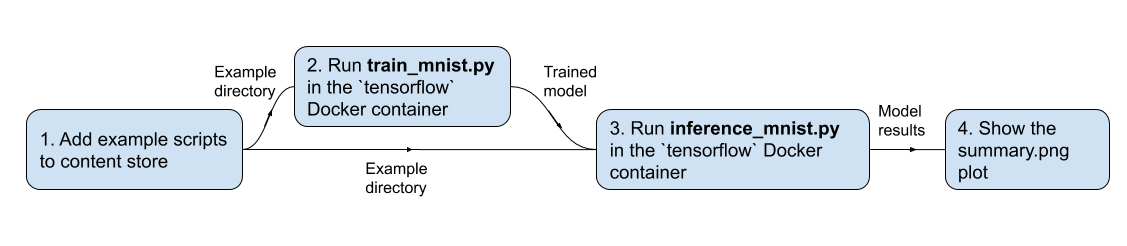

Let's get started.

First, we need to enable a couple of Haskell language extensions and run some imports:

In [1]:
:opt no-lint

{-# LANGUAGE Arrows #-}
{-# LANGUAGE OverloadedStrings #-}
{-# LANGUAGE QuasiQuotes #-}

-- Funflow libraries
import qualified Data.CAS.ContentStore as CS
import Funflow
  ( Flow,
    dockerFlow,
    ioFlow,
    getDirFlow,
    pureFlow,
    putDirFlow,
    runFlowWithConfig,
    RunFlowConfig(..)
  )
import qualified Funflow.Tasks.Docker as DE

-- Other libraries
import Path (toFilePath, Abs, Dir, Path, Rel, File, absdir, mkRelDir, parseAbsDir, relfile, reldir, (</>))
import Path.IO (makeAbsolute)
import System.Directory (getCurrentDirectory)
import Codec.Picture (readImage, DynamicImage, generateImage, convertRGB16, PixelRGB16 (..))

## Task 1. Adding data to the `funflow` content store

Since we are using the pre-built `tensorflow` Docker container, we'll need to mount our scripts to it as a volume. To promote reproducibility, `funflow` only supports mounting host directories to docker containers using its internal content store which keeps track of directory contents via hashes. This means that we'll need to ingest our script directory before running any Docker tasks: 

In [2]:
-- | Helper for getting the absolute path to the tensorflow example directory
tfExampleDir :: () -> IO (Path Abs Dir)
tfExampleDir _ = do
  cwd <- getCurrentDirectory
  cwdAbs <- parseAbsDir cwd
  return $ cwdAbs </> [reldir|./tensorflow-example|]

-- | A `Flow` which copies the tensorflow example to the content store
-- so it can be used in downstream tasks
copyExampleToStore :: Flow () CS.Item
copyExampleToStore = proc _ -> do
  exampleDir <- ioFlow tfExampleDir -< ()
  putDirFlow -< exampleDir

## Task 2. Training the model

Now that we've defined a task for adding our Python scripts to the content store, we are ready to define a docker task which will run our model training script.

The output of our script is a serialized version of our model. Docker tasks in `funflow` return a content store directory of type `CS.Item` containing all files generated in the container's working directory. 

In [3]:
trainTaskConfig :: DE.DockerTaskConfig
trainTaskConfig =
  DE.DockerTaskConfig
    { DE.image = "tensorflow/tensorflow:2.3.0",
      DE.command = "bash",
      -- Note: we are installing our script's requirements so we can use the default tensorflow image
      -- we could have also prepared an image with these requirements already installed.
      DE.args =
        [ "-c",
          "pip install -r /tensorflow-example/requirements.txt && \
          \ python /tensorflow-example/train_mnist.py --n_epochs 10 ./model"
        ]
    }

-- | Trains a tensorflow digit recognition model and outputs the serialized model
trainModel :: Flow CS.Item CS.Item
trainModel = proc exampleItem -> do
  -- Define a volume for the example directory
  let exampleVolume = DE.VolumeBinding {DE.item = exampleItem, DE.mount = [absdir|/tensorflow-example/|]}
  (dockerFlow trainTaskConfig) -< DE.DockerTaskInput {DE.inputBindings = [exampleVolume], DE.argsVals = mempty}


## Task 3. Making predictions

With our model trained, the final task in our flow is to run the model on a set of demo images which are included with the example scripts. Since the trained model was output from our training task as a content store item, we can mount it directly to the container in our next Docker task.

In [5]:
inferenceTaskConfig :: DE.DockerTaskConfig
inferenceTaskConfig = 
  DE.DockerTaskConfig
    { DE.image = "tensorflow/tensorflow:2.3.0",
      DE.command = "bash",
      DE.args =
      [ "-c",
       "pip install -r /tensorflow-example/requirements.txt && \
      \ python /tensorflow-example/inference_mnist.py /trained/model /tensorflow-example/demo-images ./summary.png"
      ]
    }
  
-- | Runs a trained tensorflow digit recognition model on some demo images and outputs a plot
-- of its classifications.
runModel :: Flow (CS.Item, CS.Item) CS.Item
runModel = proc (exampleItem, trainedModelItem) -> do
  -- Define volumes for the example directory and the previously trained model
  let exampleVolume = DE.VolumeBinding {DE.item = exampleItem, DE.mount = [absdir|/tensorflow-example/|]}
  let trainedModelVolume = DE.VolumeBinding {DE.item = trainedModelItem, DE.mount = [absdir|/trained/|]}
  dockerFlow inferenceTaskConfig -< DE.DockerTaskInput {DE.inputBindings = [exampleVolume, trainedModelVolume], DE.argsVals = mempty}
  

## Task 4.  Displaying model results
The `inference_mnist.py` script outputs a plot summarizing its predictions for the demo images. We can create a simple `IOFlow` to read this file and render it.

In [7]:
-- | Helper function for reading an image file with a consistent
-- return type. If the image file can't be read, a default black 
-- image will be returned.
readImageWithDefault :: String -> IO (Image PixelRGB16)
readImageWithDefault imagePath = do 
    img <- readImage imagePath
    case img of 
      Left errorMessage -> do
          putStrLn "There was an error reading the image file"
          putStrLn errorMessage
          putStrLn "Returning a blank default image"
          return $ generateImage (\x y -> PixelRGB16 0 0 0) 128 128
      Right img -> return $ convertRGB16 img 
      
plotSummary :: Flow String (Image PixelRGB16)
plotSummary = ioFlow readImageWithDefault

## Constructing and running the flow
With that, we are ready to construct our final `Flow` DAG

In [10]:
flow :: Flow () (Image PixelRGB16)
flow = proc _ -> do
  -- 1. Add the example to the content store
  tensorflowExample <- copyExampleToStore -< ()
  
  -- 2. Train the model
  trainedModel <- trainModel -< tensorflowExample
  
  -- 3. Run the newly trained model on the images included in the example directory
  modelSummary <- runModel -< (tensorflowExample, trainedModel)
  -- Get the absolute path of the content store directory where the outputs for `inference_mnist.py`
  -- were saved.
  outputDir <- getDirFlow -< modelSummary
  -- inference_mnist.py creates a summary plot in its output directory under the name `summary.png`. 
  -- we can write another simple flow to append this to the output path we found in the previous task.
  summaryFile <- pureFlow (\x -> toFilePath (x </> [relfile|summary.png|])) -< outputDir
  
  -- 4. And finally, we can read the summary plot file and return it as an Image so it can be rendered.
  plotSummary -< summaryFile

And finally, we can run the flow and show its output. Note that this may take a few minutes to run since we are training the model.

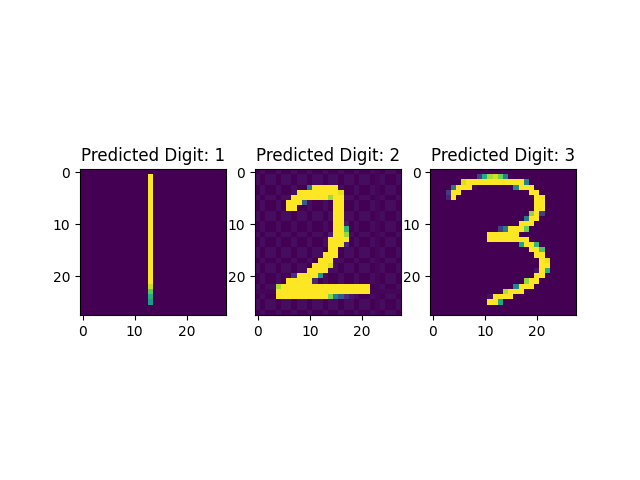

In [9]:
-- Note: using a local content store directory instead
-- of the default in the `runFlow` config. this allows the notebook
-- to work more consistently in different users' environments, 
-- but in principle you could replace this block with a 
-- simple `runFlow flow () :: IO (Image PixelRGB16)`

flowOutput :: IO (Image PixelRGB16)
flowOutput = do 
  cwd <- parseAbsDir =<< getCurrentDirectory
  let storeDirPath = cwd </> [reldir|./.tmp/store|]
  (runFlowWithConfig RunFlowConfig {storePath = storeDirPath, configFile = Nothing}) flow ()

-- We need to call the value so the output gets rendered in the Jupyter notebook.
flowOutput